# BBC News Classification

**DTSA 5510 Unsupervised Algorithms in Machine Learning**

**University of Colorado Boulder**

This notebook explores the classification of BBC news articles into five categories using both unsupervised and supervised machine learning approaches. The unsupervised method uses Truncated SVD for topic modeling and cosine similarity for prediction. To compare this method with a supervised approach, I’ve implemented a Random Forest Classifier. The project includes exploratory data analysis, hyperparameter tuning, model evaluation, and my final submission to the Kaggle competition.

## Import Modules

This section imports necessary Python libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), natural language processing (nltk), and machine learning (sklearn). Warnings are suppressed to avoid clutter from known issues like the token_pattern warning from TfidfVectorizer and a pandas formatting issue. I rely on these modules for data loading, text preprocessing, model training, and performance evaluation throughout this notebook.

In [5]:
# data manipulation
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# natural language tool kit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# sci-kit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  
from sklearn.feature_selection import chi2
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# regex
import re

# warnings
import warnings

In [6]:
warnings.filterwarnings('ignore', message="The parameter 'token_pattern' will not be used")
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

## Load Data

This section downloads the NLTK stopwords dataset, which are low-information words that will be diregarded in the model, and loads the BBC News Train and Test CSV files from Kaggle. The train data includes news articles, their categories, and their article IDs while the test data excludes the categories, which is the target for this data set.

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
train_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

# Unsupervised Approach - Truncated SVD

SUmmary of truncated sVD

## Exploratory Data Analysis

In this section, I analyze the BBC News dataset to undertstand its characteristics and determine the completeness of the set. Initial checks of the data set show 1490 training and 735 testing samples, no missing values, and no duplicates. The articles fall under 5 relatively balanced categories: business, entertainment, politics, sports, and tech. Each category has between 200 and 350 articles. Of the categories, tech has the most words, and entertainment has the least. The richest vocabulary with the most unique words, as seen in the visualization below, belongs to the entertainment. The politics category has the least rich vocabulary. 


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB

Train Data Shape: (1490, 3)

Test Data Shape: (735, 2)

Training Data Head:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  busine

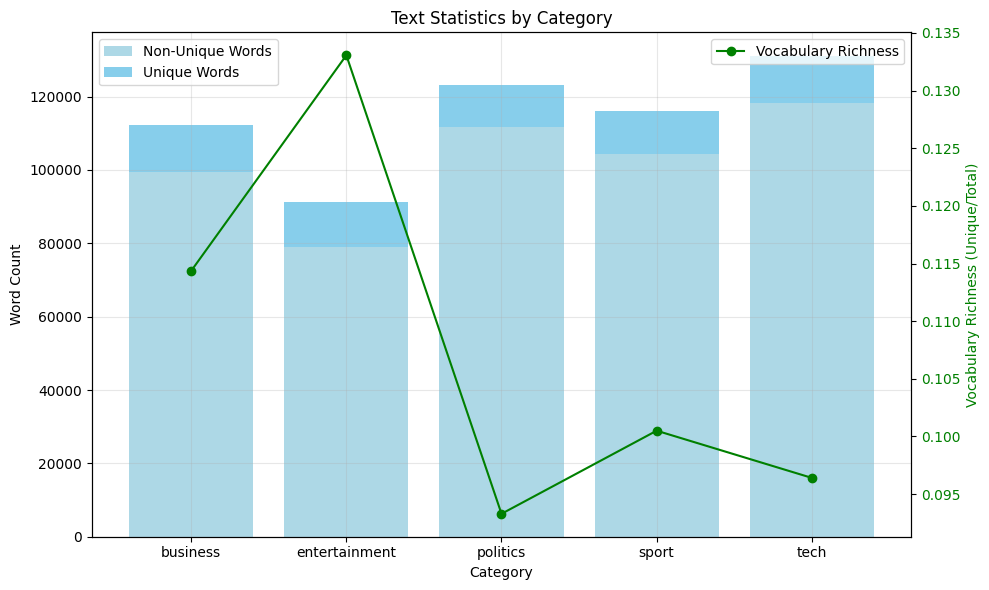

In [9]:
print('\nTraining Data Info:')
train_data.info()

print('\nTesting Data Info:')
test_data.info()

print('\nTrain Data Shape:', train_data.shape)
print('\nTest Data Shape:', test_data.shape)

print('\nTraining Data Head:')
print(train_data.head())

print("\nMissing values in Training Set:")
print(train_data.isnull().sum())
print("\nMissing Values in Test Set:")
print(test_data.isnull().sum())

print("\nDuplicated values in Training Set:")
print(train_data.duplicated().sum())
print("\nDuplicated Values in Test Set:")
print(test_data.duplicated().sum())

print("\nCategory Counts in Train Set:")
category_counts = train_data['Category'].value_counts()
print(category_counts)

texts_by_category = train_data.groupby('Category')['Text'].apply(list)
category_stats = {}
for category, texts in texts_by_category.items():
    combined_text = ' '.join(texts)
    all_words = combined_text.lower().split()
    total_words = len(all_words)
    unique_words = len(set(all_words))
    category_stats[category] = {
        'total_words': total_words,
        'unique_words': unique_words,
        'vocabulary_richness': unique_words / total_words
    }

stats_df = pd.DataFrame.from_dict(category_stats, orient='index')
print("\nText Statistics by Category:")
print(stats_df)

fig, ax1 = plt.subplots(figsize=(10, 6))
stats_df['non_unique_words'] = stats_df['total_words'] - stats_df['unique_words']
ax1.bar(stats_df.index, stats_df['non_unique_words'], label='Non-Unique Words', color='lightblue')
ax1.bar(stats_df.index, stats_df['unique_words'], bottom=stats_df['non_unique_words'], label='Unique Words', color='skyblue')
ax1.set_xlabel('Category')
ax1.set_ylabel('Word Count')
ax1.set_title('Text Statistics by Category')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(stats_df.index, stats_df['vocabulary_richness'], color='green', marker='o', label='Vocabulary Richness')
ax2.set_ylabel('Vocabulary Richness (Unique/Total)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

explanation

## Data Preprocessing

In [ ]:
def process_stop_words(stopwords_list):
    
    stop_words_set = set()
    for word in stopwords_list:
        
        processed_word = word.lower()
        processed_word = re.sub(r'[^\w\s]', '', processed_word)
        processed_word = re.sub(r'\d+', '', processed_word)
        
        if processed_word:
            
            stemmed_word = stemmer.stem(processed_word)
            stop_words_set.add(stemmed_word)
    
    return list(stop_words_set)

def custom_tokenizer(text):
    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    stems = [stemmer.stem(word) for word in words]
    
    return stems

def predict_labels_training(similarity_matrix, labels, exclude_self=True):

    predictions = []
    for i, sim in enumerate(similarity_matrix):

        sim[i] = -float('inf')  # Exclude self-similarity
        most_similar_idx = np.argmax(sim)
        predictions.append(labels[most_similar_idx])
    
    return predictions

In [ ]:
stemmer = SnowballStemmer('english')
stop_words = process_stop_words(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_data['Text'])

print(f"\nTF-IDF Matrix Shape (Train): {tfidf_matrix_train.shape}")
print(f"TF-IDF Matrix Shape (Test): {tfidf_matrix_test.shape}")
print(f"Number of Features: {len(tfidf_vectorizer.get_feature_names_out())}")

## Model Training & Hyperparameter Tuning

In [ ]:
train_labels = train_data['Category'].values
k_values = range(2, 11)
train_accuracies = []

plt.figure(figsize=(10,6))
for k in reversed(k_values):
    svd = TruncatedSVD(n_components=k)
    tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)

    train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
    train_predictions = predict_labels_training(train_similarity, train_labels)
    
    train_acc = accuracy_score(train_labels, train_predictions)
    train_accuracies.append(train_acc)

    cumulative_variance = svd.explained_variance_ratio_ 
    plt.plot(range(1, k + 1), cumulative_variance, 
             label=f'k={k}', marker='o', markersize=1, linewidth=1)

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(list(k_values), list(reversed(train_accuracies)), label='Training Accuracy', marker='o', markersize=8, linewidth=2)
plt.xlabel('Number of Components (k)')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Number of SVD Components')
plt.grid(True)
plt.legend()
plt.show()

print("k | Training Accuracy")
for k, acc in zip(k_values, reversed(train_accuracies)):
    print(f"{k:<2} | {acc:.4f}")

In [ ]:

max_features_values = [1000, 5000, 10000, None]  
max_df_values = [0.5, 0.75, 0.9, 1.0]  
results = []

for f in max_features_values:
    
    for d in max_df_values:
        
        tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=d, max_features=f)
        tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])

        svd = TruncatedSVD(n_components=5)
        tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)

        train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
        train_predictions = predict_labels_training(train_similarity, train_labels)
        
        train_acc = accuracy_score(train_labels, train_predictions)
        results.append({'max_features': f, 'max_df': d, 'train_accuracy': train_acc})

results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(results_df)

In [ ]:
best_hyperparams = results_df[results_df['train_accuracy'] == results_df['train_accuracy'].max()]
print(best_hyperparams)

## Final Model Build & Prediction

In [ ]:
# final hyperparameters
#k_final = 5
#max_features_final = None
#max_df_final = 0.90
k_final = 5
max_features_final = 10000
max_df_final = 1.00

# preprocess data
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_data['Text'])

# train and fit truncated SVD
svd = TruncatedSVD(n_components=k_final)
tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)
tfidf_SVD_test = svd.transform(tfidf_matrix_test)

# train
train_similarity = cosine_similarity(tfidf_SVD_train, tfidf_SVD_train)
train_predictions = predict_labels_training(train_similarity, train_labels, exclude_self=True)

# create training set confusion matrix
cm = confusion_matrix(train_labels, train_predictions)
plt.figure(figsize=(10, 8))
categories = np.unique(train_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title(f'Confusion Matrix for Unsupervised Training Predictions (k={k_final}, max_df={max_df_final}, max_features=all)')
plt.show()
print(f"\nUnsupervised (k={k_final}) Training Classification Report:")
print(classification_report(train_labels, train_predictions))

# predict on testing set and save for submission
test_similarity = cosine_similarity(tfidf_SVD_test, tfidf_SVD_train)
test_predictions = predict_labels_training(test_similarity, train_labels)
submission = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_predictions})
submission.to_csv('submission.csv', index=False)

# Supervised Approach - Random Forrest Classifier

## Data Preprocessing

In [ ]:
rf_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
rf_tfidf_matrix_train = rf_tfidf_vectorizer.fit_transform(train_data['Text'])

## Training Validation & Data Size Search

In [ ]:
train_labels = train_data['Category']
train_sizes = [0.1, 0.2, 0.5]
train_size_results = []

for size in train_sizes:
    
    X_train, X_val, y_train, y_val = train_test_split(rf_tfidf_matrix_train, train_labels, train_size=size, random_state=19)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    train_preds = rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)
    
    val_preds = rf.predict(X_val)
    val_acc = accuracy_score(y_val, val_preds)
    
    train_size_results.append({'train_size': f"{int(size * 100)}%", 'train_accuracy': train_acc, 'val_accuracy': val_acc})
    #print(f"Train size: {int(size * 100)}%, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

train_size_results_df = pd.DataFrame(train_size_results)
print("\nRandomForest Data Size Tuning Results:")
print(train_size_results_df)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(rf_tfidf_matrix_train, train_labels, train_size=0.5, random_state=19)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)


train_preds = rf.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

val_preds = rf.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)

cm_val = confusion_matrix(y_val, val_preds)
categories = np.unique(train_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix for Random Forest Validation (Holdout) Predictions')

## Predict on Testing Set

In [ ]:
print(rf_tfidf_matrix_test.shape)

In [ ]:
# random forest
rf = RandomForestClassifier()

# train
rf_tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=max_df_final, max_features=max_features_final)
rf_tfidf_matrix_train = rf_tfidf_vectorizer.fit_transform(train_data['Text'])
rf.fit(rf_tfidf_matrix_train, train_labels)

# predict
rf_tfidf_matrix_test = rf_tfidf_vectorizer.transform(test_data['Text'])
test_preds = rf.predict(rf_tfidf_matrix_test)


submission = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_preds})
#submission.to_csv('submission.csv', index=False)
#print(submission.head())

In [ ]:
#!rm -rf /kaggle/working/*